In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import cv2 
from PIL import Image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pytorch_lightning import LightningModule

import os
import sys
import random
import tqdm

sys.path.append("/home/tak/IBT/Image-back-translation")

In [2]:
class MixAugLitModule(LightningModule):
    def __init__(self, net, num_classes, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.net = net
        self.num_classes = num_classes
        # 나머지 코드
        
    def forward(self, x):
        return self.net(x)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model1_path = '/nvme_data1/tak/wandb/concat/runs/2023-11-05_00-56-40/checkpoints/last.ckpt' # aug_num=5
model2_path = '/nvme_data1/tak/wandb/concat/runs/2023-11-06_00-21-24/checkpoints/last.ckpt' # aug_num=0

val_dir = '/nvme_data1/tak/val_formatted'


model1 = MixAugLitModule.load_from_checkpoint(model1_path)
model1.eval()  # Set to evaluation mode
model1.to(device)

model2 = MixAugLitModule.load_from_checkpoint(model2_path)
model2.eval()  # Set to evaluation mode
model2.to(device)


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(val_dir, transform=transform)

# option 1. Load random image
dataloader = DataLoader(dataset, batch_size=512, shuffle=True, num_workers=32)

cuda


In [4]:
# 렌더링할 이미지 리스트 초기화
selected_images = []

# 데이터셋을 반복하면서 각 이미지에 대해 두 모델의 예측을 비교
for images, labels in tqdm.tqdm(dataloader):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs1 = model1(images)
        outputs2 = model2(images)

    # 예측 결과 비교
    _, preds1 = torch.max(outputs1, 1)
    _, preds2 = torch.max(outputs2, 1)

    for i in range(images.size(0)):
        if preds1[i] == labels[i] and preds2[i] != labels[i]:
            # 조건에 맞는 경우 이미지 정보 저장
            selected_images.append(images[i].cpu())

100%|██████████| 98/98 [06:00<00:00,  3.68s/it]


In [5]:
print(len(selected_images))

6995


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


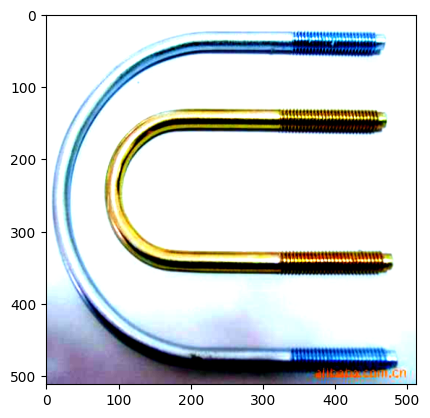

In [7]:
plt.imshow(selected_images[0].permute(1, 2, 0))